# Analyzer augmentations
All analyzers implemented in ExplainableAI.jl can be augmented by two types of augmentations:
`NoiseAugmentation`s and `InterpolationAugmentation`s.
These augmentations are wrappers around analyzers
that modify the input before passing it to the analyzer.

We build on the basics shown in the *Getting started* section
and start out by loading the same pre-trained LeNet5 model and MNIST input data:

In [1]:
using ExplainableAI
using VisionHeatmaps
using Zygote
using Flux

using BSON # hide
model = BSON.load("../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.344 KiB.

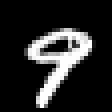

In [2]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

convert2image(MNIST, x)

## Noise augmentation
The `NoiseAugmentation` wrapper computes explanations averaged over noisy inputs.
Let's demonstrate this on the `Gradient` analyzer.
First, we compute the heatmap of an explanation without augmentation:

""

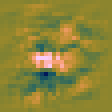

In [3]:
analyzer = Gradient(model)
heatmap(input, analyzer)

Now we wrap the analyzer in a `NoiseAugmentation` with 10 samples of noise.
By default, the noise is sampled from a Gaussian distribution
with mean 0 and standard deviation 1.

Sampling NoiseAugmentation... 100%|██████████████████████| Time: 0:00:01


""

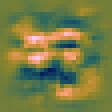

In [4]:
analyzer = NoiseAugmentation(Gradient(model), 50)
heatmap(input, analyzer)

Note that a higher sample size is desired, as it will lead to a smoother heatmap.
However, this comes at the cost of a longer computation time.

We can also set the standard deviation of the Gaussian distribution:

""

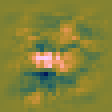

In [5]:
analyzer = NoiseAugmentation(Gradient(model), 50, 0.1)
heatmap(input, analyzer)

When used with a `Gradient` analyzer, this is equivalent to `SmoothGrad`:

""

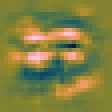

In [6]:
analyzer = SmoothGrad(model, 50)
heatmap(input, analyzer)

We can also use any distribution from
[Distributions.jl](https://github.com/JuliaStats/Distributions.jl),
for example Poisson noise with rate $\lambda=0.5$:

""

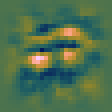

In [7]:
using Distributions

analyzer = NoiseAugmentation(Gradient(model), 50, Poisson(0.5))
heatmap(input, analyzer)

Is is also possible to define your own distributions or mixture distributions.

`NoiseAugmentation` can be combined with any analyzer type from the Julia-XAI ecosystem,
for example `LRP` from [RelevancePropagation.jl](https://github.com/Julia-XAI/RelevancePropagation.jl).

## Integration augmentation
The `InterpolationAugmentation` wrapper computes explanations
averaged over `n` steps of linear interpolation between the input and a reference input,
which is set to `zero(input)` by default:

""

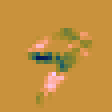

In [8]:
analyzer = InterpolationAugmentation(Gradient(model), 50)
heatmap(input, analyzer)

When used with a `Gradient` analyzer, this is equivalent to `IntegratedGradients`:

""

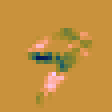

In [9]:
analyzer = IntegratedGradients(model, 50)
heatmap(input, analyzer)

To select a different reference input, pass it to the `analyze` function
using the keyword argument `input_ref`.
Note that this is an arbitrary example for the sake of demonstration.

""

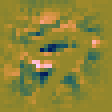

In [10]:
matrix_of_ones = ones(Float32, size(input))

analyzer = InterpolationAugmentation(Gradient(model), 50)
expl = analyzer(input; input_ref=matrix_of_ones)
heatmap(expl)

Once again, `InterpolationAugmentation` can be combined with any analyzer type from the Julia-XAI ecosystem,
for example `LRP` from [RelevancePropagation.jl](https://github.com/Julia-XAI/RelevancePropagation.jl).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*